# 如何调整你的赌注 - 凯利法则

凯利规则在赌博中有着悠久的历史，因为它提供了关于在不同（但有利）赔率的（无限）投注序列中的每一个下注多少以最大化最终财富的指导。它于 1956 年由 Claude Shannon 在贝尔实验室的同事 John Kelly 作为信息率的新解释发表。他对新问答节目 The $64,000 Question 中对候选人的赌注很感兴趣，西海岸的一位观众利用三个小时的延迟来获取有关获胜者的内幕信息。

凯利将香农的信息理论联系起来，以解决在赔率有利但不确定性仍然存在的情况下对长期资本增长的最佳赌注。他的规则最大化对数财富作为每场比赛成功几率的函数，并且包括隐含的破产保护，因为 log(0) 是负无穷大，因此凯利赌徒自然会避免失去一切。


## 导入库

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
DATA_STORE = Path('..', 'data', 'assets.h5')

## 下注的最佳大小

凯利首先分析了具有二元输赢结果的游戏。关键变量是：
- b：赔率定义了 \\$1 投注的赢取金额。赔率 = 5/1 意味着如果投注赢了 \\$5 收益，再加上 \\$1 本金的回收。
- p：概率定义了有利结果的可能性。
- f：要下注的当前资本的份额。
- V：作为投注结果的资本价值。

凯利法则旨在使无限重复投注的价值增长率 G 最大化（请参阅第 5 章了解背景知识）。
$$G=\lim_{N\rightarrow\infty}=\frac{1}{N}\log\frac{V_N}{V_0}$$

我们可以通过相对于 f 最大化 G 来最大化增长率 G，如下所示使用 sympy：

In [5]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [6]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

## 获取标准普尔 500 数据

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close

### 计算回报和标准差

In [8]:
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500')

In [9]:
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()

In [10]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

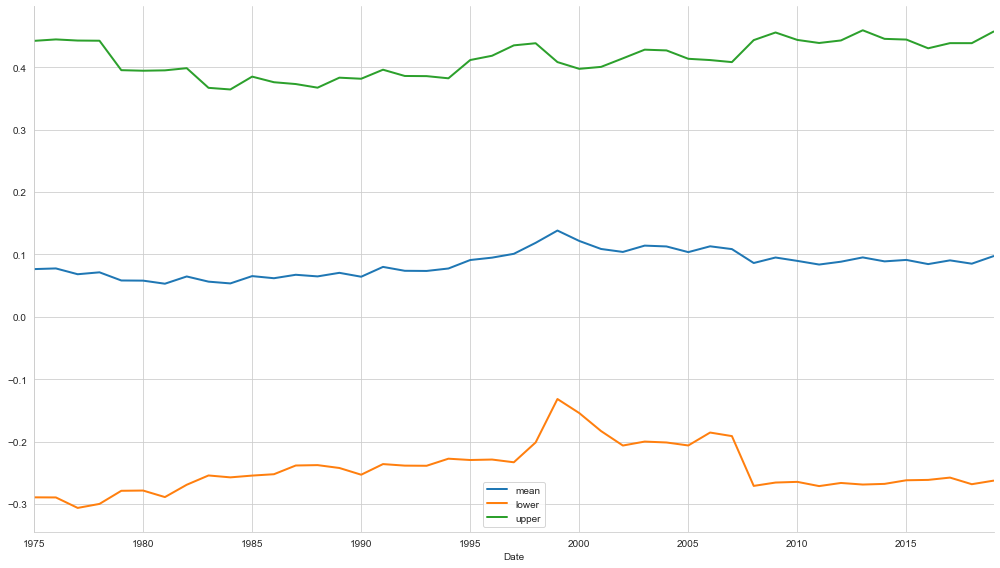

In [11]:
return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

### 单一资产的凯利法则 - 指数回报

在金融市场环境中，结果和备选方案都更​​加复杂，但凯利规则逻辑仍然适用。 Ed Thorp 使它流行起来，他首先将它应用于赌博（在 Beat the Dealer 中有所描述）并随后创办了成功的对冲基金 Princeton/Newport Partners。

对于连续的结果，资本的增长率由不同回报率的概率分布的积分来定义，可以在数值上进行优化。
我们可以使用 `scipy.optimize` 模块求解这个表达式（见书）以获得最佳 f*：

In [12]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), 
                               mean - 3 * std, 
                               mean + 3 * std)
    return -val

In [13]:
def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

In [14]:
def get_kelly_share(data):
    solution = minimize_scalar(norm_integral, 
                        args=(data['mean'], data['std']), 
                        bounds=[0, 2], 
                        method='bounded') 
    return solution.x

In [15]:
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)

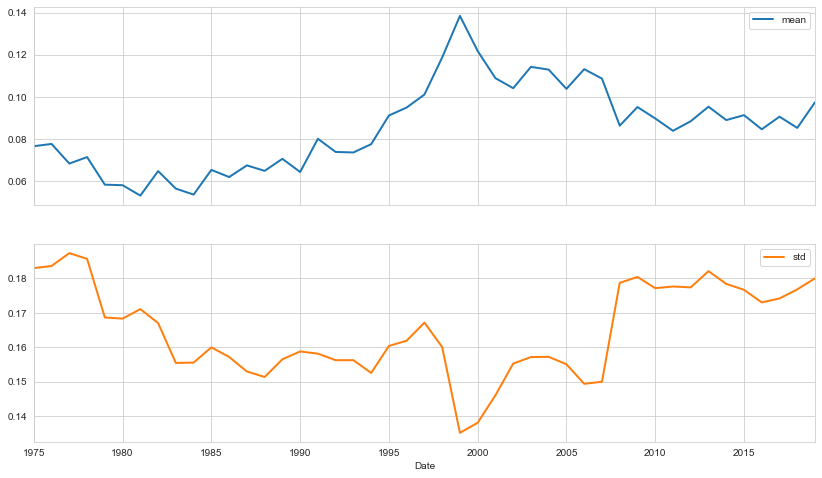

In [16]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [17]:
annual_returns.tail()

,sp500,f
Date,,
2015-12-31,-0.007266,1.999996
2016-12-31,0.095350,1.999996
2017-12-31,0.194200,1.999996
2018-12-31,-0.062373,1.999996
2019-12-31,0.288781,1.999996


### 绩效评估

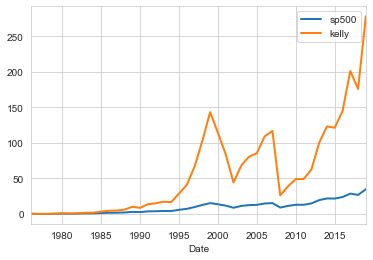

In [18]:
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));


In [19]:
annual_returns.f.describe()

count    45.000000
mean      1.979025
std       0.062282
min       1.708206
25%       1.999996
50%       1.999996
75%       1.999996
max       1.999996
Name: f, dtype: float64

In [20]:
return_ci.head()

,mean,lower,upper
Date,,,
1975-12-31,0.076574,-0.289442,0.442591
1976-12-31,0.077649,-0.289600,0.444897
1977-12-31,0.068336,-0.306402,0.443074
1978-12-31,0.071410,-0.299973,0.442794
1979-12-31,0.058325,-0.278930,0.395581


### 计算凯利分数

In [21]:
m = .058
s = .216

In [22]:
# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 1.1974


In [23]:
# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

Optimal Kelly fraction: 1.1974


## 多种资产的凯利法则

我们将使用各种股票的示例。 [E. Chan (2008)](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889) 说明了如何实现凯利规则的多资产应用，结果是相当于来自均值方差优化的（潜在杠杆）最大夏普比率投资组合。

计算涉及精度矩阵（协方差矩阵的逆矩阵）和返回矩阵的点积：

In [25]:
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [26]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 455 entries, MMM to ZTS
dtypes: float64(455)
memory usage: 49.7 MB


In [27]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 192 entries, MMM to XEL
dtypes: float64(192)
memory usage: 541.3 KB


### 计算精度矩阵

In [28]:
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

In [29]:
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

In [30]:
kelly_allocation.describe()

count    192.000000
mean       0.254534
std        3.377155
min       -9.604965
25%       -1.724042
50%        0.215364
75%        2.220286
max        9.393917
dtype: float64

In [31]:
kelly_allocation.sum()

48.87044647781846

### 最大的投资组合分配

The plot shows the tickers that receive an allocation weight > 5x their value:

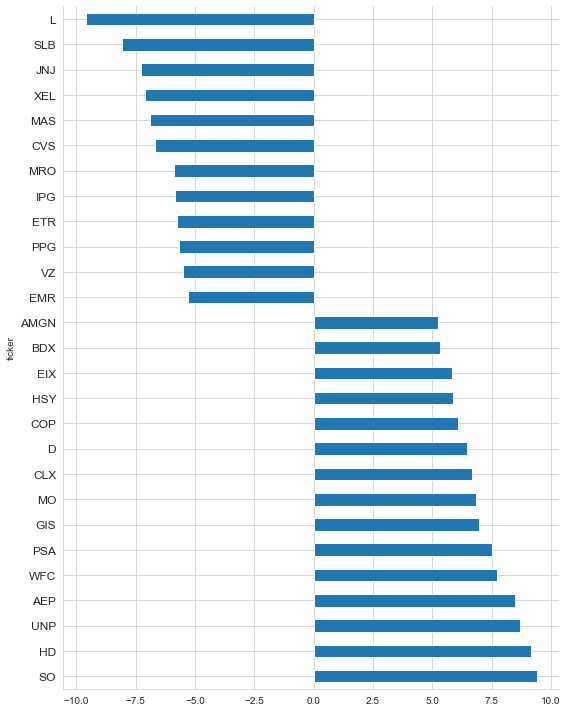

In [32]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

### 性能与 SP500

凯利规则确实很好。但它也是根据历史数据计算出来的。

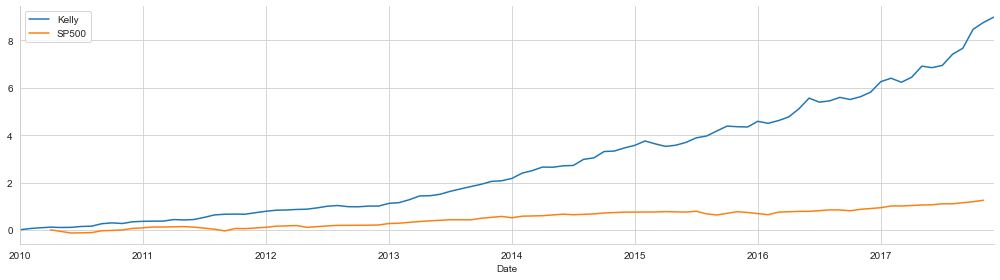

In [33]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();